# ARIMA

Esto es para la instalación de AUTOARIMA

In [1]:
# pip install pmdarima

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
%matplotlib inline
import requests
import csv

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

import plotly.express as px

In [3]:
# CSV_URL_LISTING = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=WOVNUEXRHX1P3Q98'


# with requests.Session() as s:
#     download = s.get(CSV_URL_LISTING)
#     decoded_content = download.content.decode('utf-8')
#     cr = csv.reader(decoded_content.splitlines(), delimiter=',')
#     my_list = list(cr)

# listing = pd.DataFrame(my_list, columns=("symbol", "name", "exchange", "assetType", "ipoDate", "delistingDate", "status"))
# listing.drop(listing.index[0], inplace=True)
# listing

Si no funciona el código anterior, descargar listado con el siguiente código:

In [4]:
listing = pd.read_csv("../z.TFM/listing_status.csv")
listing

symbol                                    name   exchange assetType  \
0          A                Agilent Technologies Inc       NYSE     Stock   
1         AA                              Alcoa Corp       NYSE     Stock   
2        AAA         AAF First Priority CLO Bond ETF  NYSE ARCA       ETF   
3       AAAU         Goldman Sachs Physical Gold ETF  NYSE ARCA       ETF   
4        AAC  Ares Acquisition Corporation - Class A       NYSE     Stock   
...      ...                                     ...        ...       ...   
12240   ZYME                           Zymeworks Inc       NYSE     Stock   
12241   ZYNE             Zynerba Pharmaceuticals Inc     NASDAQ     Stock   
12242   ZYXI                               Zynex Inc     NASDAQ     Stock   
12243    ZZK                                     NaN  NYSE ARCA     Stock   
12244    ZZZ                     TEST TICKER FOR UTP  NYSE ARCA     Stock   

          ipoDate  delistingDate  status  
0      1999-11-18            NaN  Active  
1      2016-10-18            NaN  Active  
2      2020-09-09            NaN  Active  
3      2018-08-15            NaN  Active  
4      2021-03-25            NaN  Active  
...           ...            ...     ...  
12240  2017-04-28            NaN  Active  
12241  2015-08-05            NaN  Active  
12242  2012-07-23            NaN  Active  
12243  2020-07-22            NaN  Active  
12244  2014-10-31            NaN  Active  

[12245 rows x 7 columns]

### DESCARGA DE DATOS Y PREPROCESADO

In [5]:
symbol = "TSLA"


year = [1,2]
month = [1,2,3,4,5,6,7,8,9,10,11,12]
real = pd.DataFrame()
     
for y in range(2):
    for m in range(12):
        URL= 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+symbol+'&interval=5min&slice=year'+str(year[y])+'month'+str(month[m])+'&apikey=UHV76ERHZOBH4LU8'
        
        with requests.Session() as s:
            download = s.get(URL)
            decoded_content = download.content.decode('utf-8')
            cr = csv.reader(decoded_content.splitlines(), delimiter=',')
            my_list = list(cr)
            
            aux = pd.DataFrame(my_list, columns=("time", "open", "high", "low", "close", "volume"))
            aux.drop(aux.index[0], inplace=True)
            real = real.append(aux, ignore_index=True)

real.sort_values("time", ascending=True, inplace=True)
real["time"] = pd.to_datetime(real["time"])
real["close"] = pd.to_numeric(real["close"])
real = real[["time", "close"]]
real.reset_index(drop=True, inplace=True)


Separamos la variable time en fecha y hora para posteriormente poder agrupar por fecha calculando la desviación típica del precio de cierre por hora

In [6]:
real['date'] = real['time'].dt.date
real['hour'] = real['time'].dt.hour

real

time     close        date  hour
0     2020-04-13 04:05:00   116.400  2020-04-13     4
1     2020-04-13 04:10:00   116.600  2020-04-13     4
2     2020-04-13 04:15:00   115.514  2020-04-13     4
3     2020-04-13 04:20:00   116.000  2020-04-13     4
4     2020-04-13 04:25:00   115.484  2020-04-13     4
...                   ...       ...         ...   ...
88976 2022-04-01 19:40:00  1091.000  2022-04-01    19
88977 2022-04-01 19:45:00  1091.100  2022-04-01    19
88978 2022-04-01 19:50:00  1090.750  2022-04-01    19
88979 2022-04-01 19:55:00  1091.000  2022-04-01    19
88980 2022-04-01 20:00:00  1091.000  2022-04-01    20

[88981 rows x 4 columns]

Calculamos la DT del precio de cierre de cada hora y agrupado por día y lo dividimos por la media del precio de cierre de cada hora y agrupado por día

In [7]:
# real = pd.DataFrame(real.groupby('date')['close'].std()/real.groupby('date')['close'].mean()*100)
real = pd.DataFrame(real.groupby('date')['close'].std()/real.groupby('date')['close'].mean()*100)
real

close
date                
2020-04-13  5.621245
2020-04-14  2.680910
2020-04-15  1.371500
2020-04-16  2.570115
2020-04-17  1.407349
...              ...
2022-03-28  2.381513
2022-03-29  0.846318
2022-03-30  0.559096
2022-03-31  0.722618
2022-04-01  0.523844

[499 rows x 1 columns]

In [8]:
real = real.dropna().reset_index()

In [9]:
real

date     close
0    2020-04-13  5.621245
1    2020-04-14  2.680910
2    2020-04-15  1.371500
3    2020-04-16  2.570115
4    2020-04-17  1.407349
..          ...       ...
494  2022-03-28  2.381513
495  2022-03-29  0.846318
496  2022-03-30  0.559096
497  2022-03-31  0.722618
498  2022-04-01  0.523844

[499 rows x 2 columns]

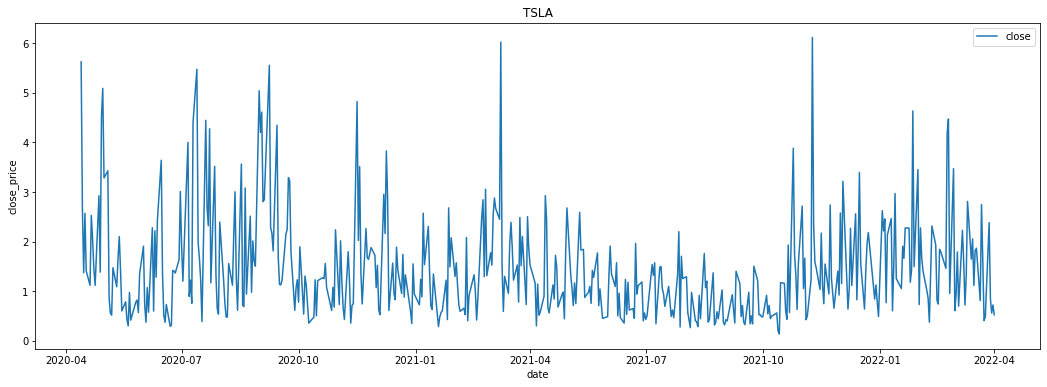

In [10]:
ax = real.plot("date", "close",figsize=(18,6), title=symbol); 
ax.set_xlabel("date");
ax.set_ylabel("close_price");


### DESCOMPOSICIÓN


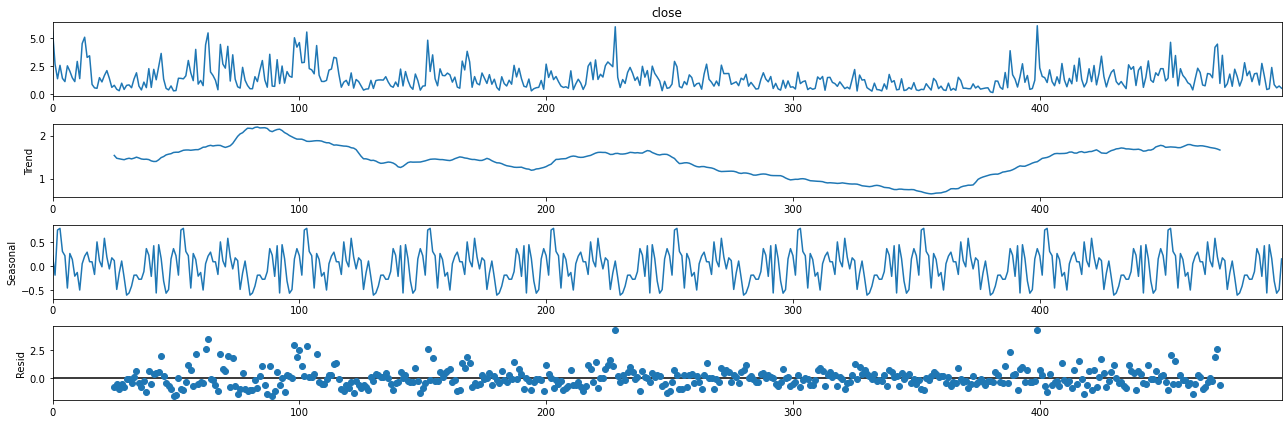

In [11]:
additive = seasonal_decompose(real['close'], model='additive', freq=50)

with plt.rc_context():
    plt.rc("figure", figsize=(18,6))
    additive.plot()
    plt.show()


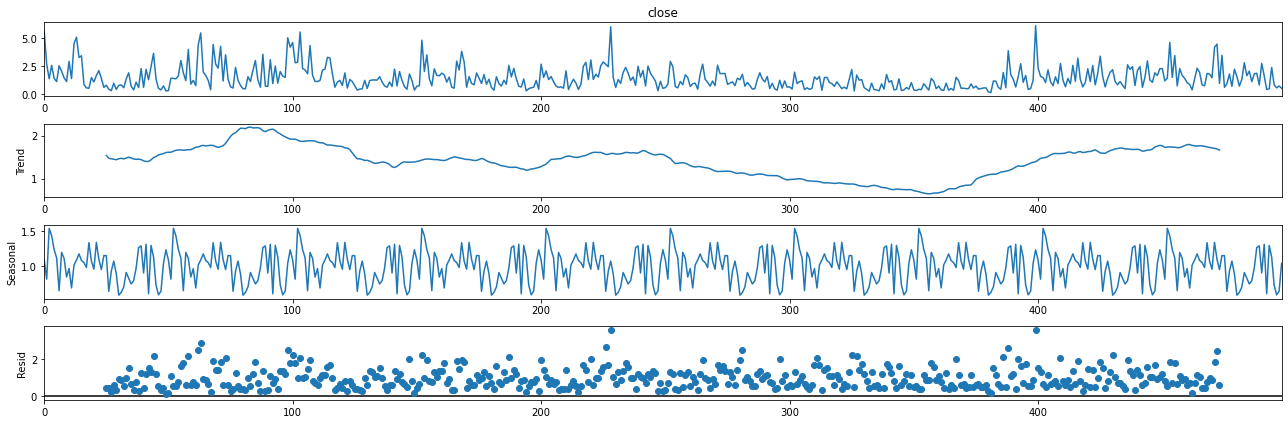

In [12]:
additive = seasonal_decompose(real['close'], model='multiplicative', freq=50)

with plt.rc_context():
    plt.rc("figure", figsize=(18,6))
    additive.plot()
    plt.show()

### AUTOCORRELACIÓN

##### Función de autocorrelación (ACF)

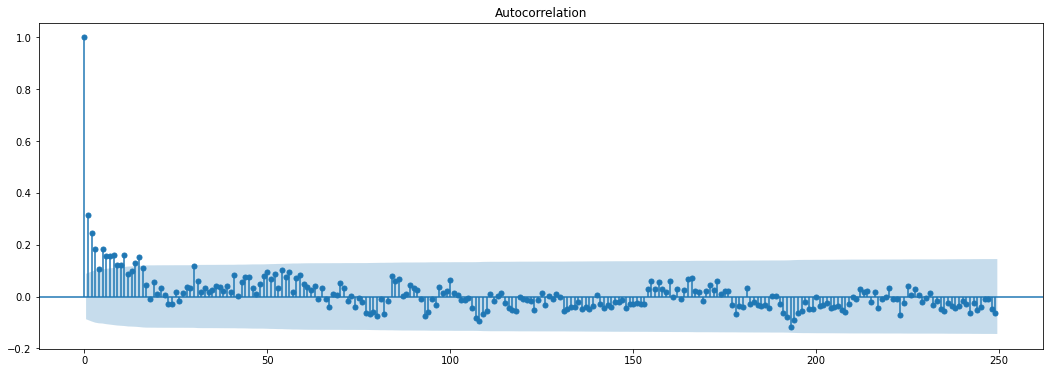

In [13]:
with plt.rc_context():
    plt.rc("figure", figsize=(18,6))
    plot_acf(real['close'], lags=np.round(len(real['close'])/2)-1);

##### Función de autocorrelación parcial (PACF)

In [14]:
# with plt.rc_context():
#     plt.rc("figure", figsize=(18,6))
#     plot_pacf(real['close'], lags=np.round(len(real['close'])/2)-1);

### TEST DICKEY FULLER AUMENTADO

Para poder llevar a cabo buenas predicciones en series temporales, necesitamos que haya **estacionariedad**

Para que haya **estacionariedad** necesitamos que:

 - La serie sea no estacional
 - No haya heterocedasticidad (es decir, que la varianza de la serie sea constante a lo largo del tiempo)
 - No haya autocorrelación (es decir, que las covarianzas de la serie son independientes del tiempo, sólo dependen del desfase entre ellas)
 
Para comprobar la estacienariedad se realiza el test de **Dickey Fuller Aumentado**:

 - H0: la serie temporal no es estacionaria
 - H1: la serie temporal es estacionaria
 
Si el **p-valor** de la salida es inferior a los niveles de significación habituales (alfa = 0.05), entonces podemos rechazar la hipótesis nula y concluir que la serie es estacionaria.

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(real['close'])
print("The p-value: ", adf_test[1])

The p-value:  1.1455201690910455e-09


In [16]:
adf_test[1]

1.1455201690910455e-09

### AUTOARIMA

In [17]:
import pmdarima as pm

# Coefficients
auto_arima = pm.auto_arima(real['close'], seasonal=False, m=0) #m es el componente estacional
trend_order = auto_arima.order

print('ARIMA COEFFICIENTS:\n')
print('AR (p): ' + str(auto_arima.order[0]))
print('I (d): ' + str(auto_arima.order[1]))
print('MA (q): ' + str(auto_arima.order[2]))

ARIMA COEFFICIENTS:

AR (p): 1
I (d): 1
MA (q): 2


### SEPARACIÓN ENTRE TRAIN Y TEST

In [18]:
# train, test = train_test_split(real, test_size=0.2)

In [19]:
TEST_SIZE = 0.2

train = real[:(int(len(real)*(1-TEST_SIZE)))]
test = real[(int(len(real)*(1-TEST_SIZE))):]


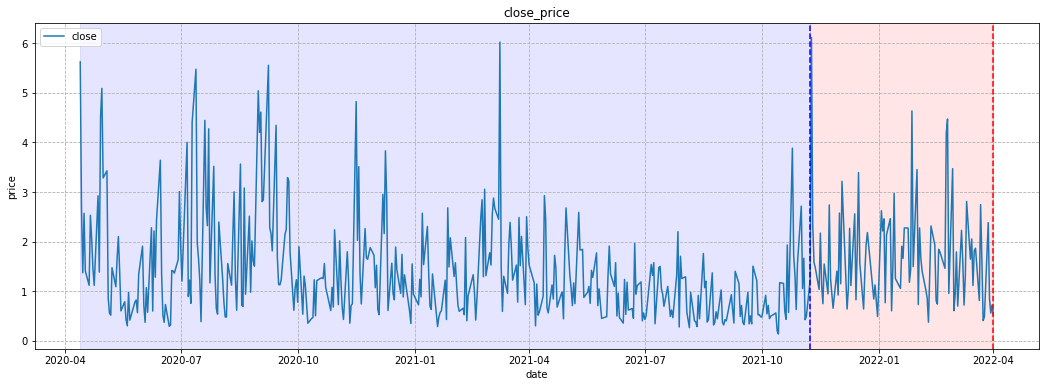

In [20]:

# Visualización
ax = real.plot("date", "close",figsize=(18,6), title='close_price');  

init__limit = real["date"][0]  
train_limit = real["date"][len(train)-1] 
test__limit = real["date"][len(train)+len(test)-1] 

ax.axvline(train_limit, linestyle='--', color='blue')
ax.axvline(test__limit, linestyle='--', color='red')

ax.axvspan(init__limit, train_limit, alpha=0.1, color='blue')
ax.axvspan(train_limit, test__limit, alpha=0.1, color='red')

# ax.text(real["time"][int((len(train)-1)*0.5)], 610, 'Train set', fontsize=18)
# ax.text(real["time"][int(len(train)+(len(test)-1)*0.3)], 610, 'Test set', fontsize=18)

ax.grid(linestyle='--')

ax.set_xlabel("date");
ax.set_ylabel("price");

In [21]:
Metrics = pd.DataFrame(columns=['Model', 'R2'])

### Naive Forecast

No handles with labels found to put in legend.


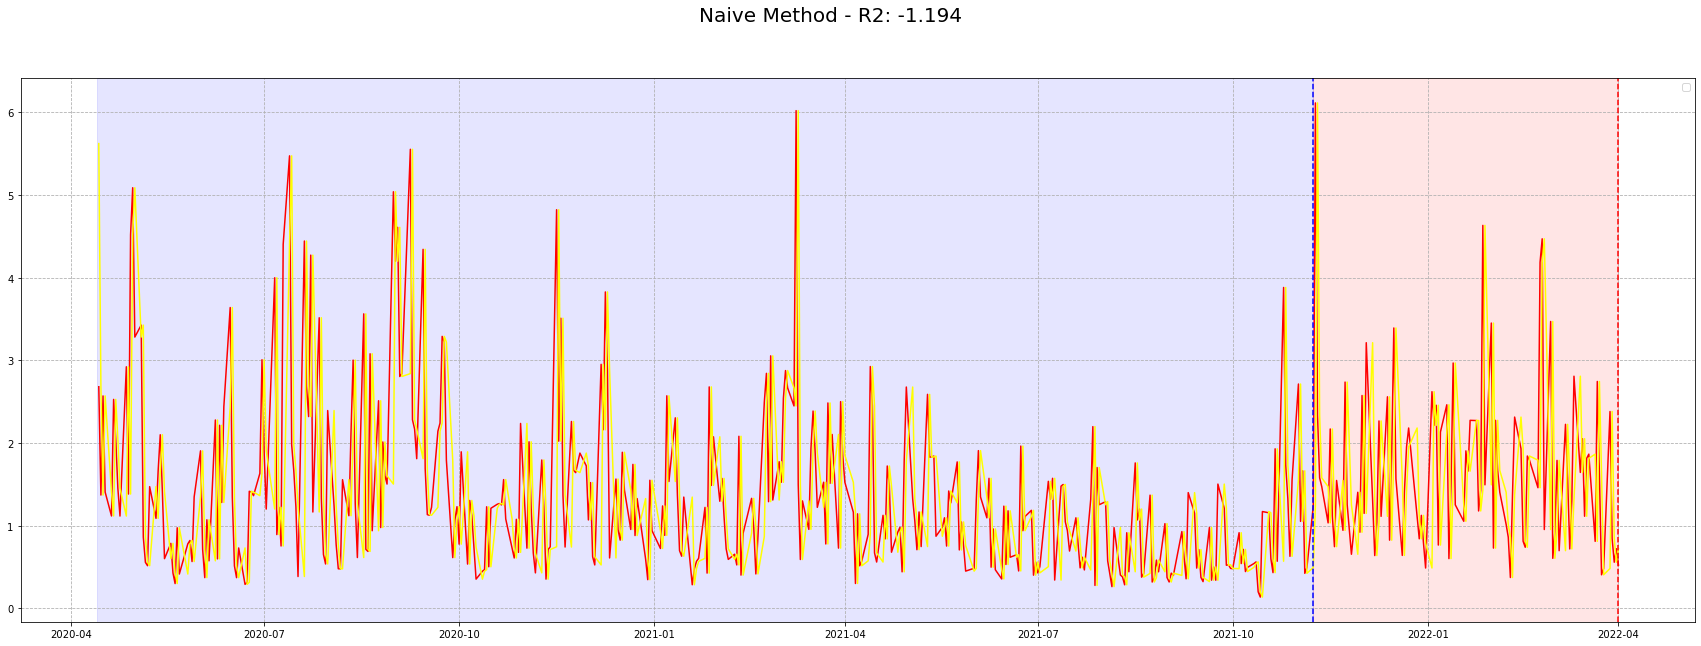

In [22]:
# Model
MODEL = 'Naive Method'

# Training model
fitted_train = train.shift(periods=1)

# Get Test Set Predictions
predict_test = test.shift(periods=1)

# Get RMSE from Test Set
real_values = test['close'][1:]
pred_values = predict_test['close'][1:]
r2 = r2_score(real_values, pred_values)

# Get predictions from whole set
predictions = real.shift(periods=1)

# Preparing data to plot
real_plot = real['close']
pred_plot = predictions['close']

# Visualization
fig, ax = plt.subplots(figsize=(30, 10))


ax.plot(real["date"][1:], real_plot[1:], color="red")
ax.plot(real["date"][1:], pred_plot[1:], color="yellow")

plt.suptitle(MODEL + ' - R2: ' + str(np.round(r2, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'R2':np.round(r2, 3)}
Metrics = Metrics.append(metric_data, ignore_index=True)




### Probando con AUTOARIMA

In [23]:
# Coefficients
p=auto_arima.order[0]
d=auto_arima.order[1]
q=auto_arima.order[2]

# Model
MODEL = 'ARIMA Process ('+str(p)+','+str(d)+','+str(q)+')'
MODEL

'ARIMA Process (1,1,2)'

No handles with labels found to put in legend.


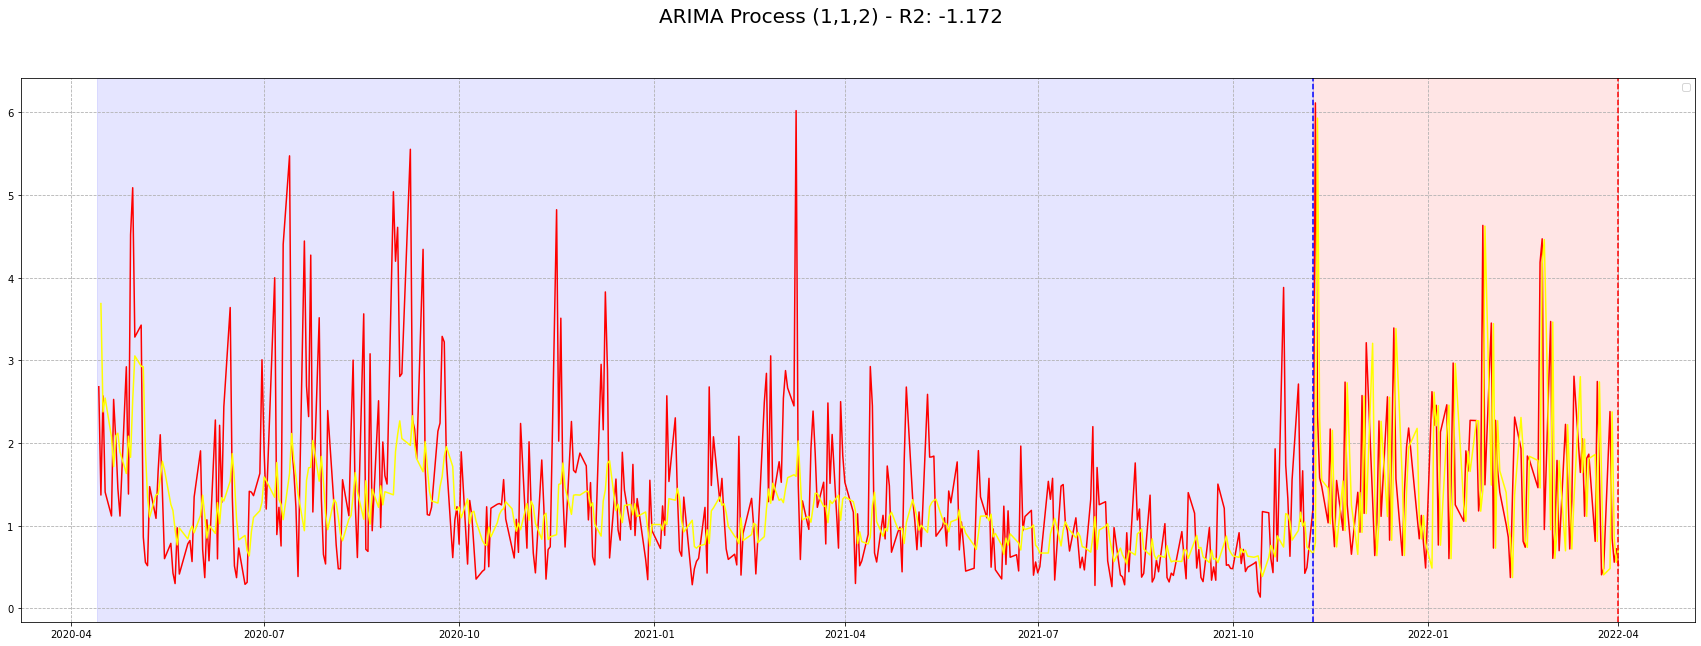

In [24]:
# Applying log
real_log = np.log(real["close"])
train_log = np.log(train["close"])
test_log = np.log(test["close"])

# Training model
model = ARIMA(train_log, order=(p, d, q))
fitted_model = model.fit()
fitted_train = fitted_model.fittedvalues

#Get Test Set Predictions
predict_test = fitted_model.predict(test_log.index[0], test_log.index[len(test_log)-1])

 # Reverting from differencing
fitted_train = fitted_train + train_log.shift(periods=d)
predict_test = predict_test + test_log.shift(periods=d)

# Get normal scale
fitted_train = np.exp(fitted_train)
predict_test = np.exp(predict_test)

# Get R2 from Test Set
real_values = test['close'][d:]
pred_values = predict_test[d:]
r2 = r2_score(real_values, pred_values)

# Get predictions from whole set
predictions = fitted_model.predict(real[d:].index[0], real[d:].index[len(real[d:])-1])

# Reverting from differencing
predictions = predictions +  real_log[d:].shift(periods=d)

# Get normal scale
predictions = np.exp(predictions)

#Preparing data to plot
real_plot = real['close'][d:]
pred_plot = predictions

# Visualization


fig, ax = plt.subplots(figsize=(30, 10))


ax.plot(real["date"][1:], real_plot, color="red")
ax.plot(real["date"][1:], pred_plot, color="yellow")


plt.suptitle(MODEL + ' - R2: ' + str(np.round(r2, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'R2':np.round(r2, 3)}
Metrics = Metrics.append(metric_data, ignore_index=True)

# SCORES

In [25]:
Metrics.sort_values(by=["R2"], ascending=True)

Model     R2
0           Naive Method -1.194
1  ARIMA Process (1,1,2) -1.172

# GRÁFICA CON ZOOM

Preparamos los datos para poder hacer una gráfica en la que podamos hacer zoom para ver el lageado de la serie predicha respecto a la serie real

In [26]:
R2_test = r2_score(real_values, pred_values)
                    

In [27]:
predictions

1           NaN
2      3.686776
3      2.376773
4      2.544691
5      2.070730
         ...   
494    0.482160
495    2.376611
496    0.844576
497    0.557945
498    0.721130
Length: 498, dtype: float64

In [28]:
real

date     close
0    2020-04-13  5.621245
1    2020-04-14  2.680910
2    2020-04-15  1.371500
3    2020-04-16  2.570115
4    2020-04-17  1.407349
..          ...       ...
494  2022-03-28  2.381513
495  2022-03-29  0.846318
496  2022-03-30  0.559096
497  2022-03-31  0.722618
498  2022-04-01  0.523844

[499 rows x 2 columns]

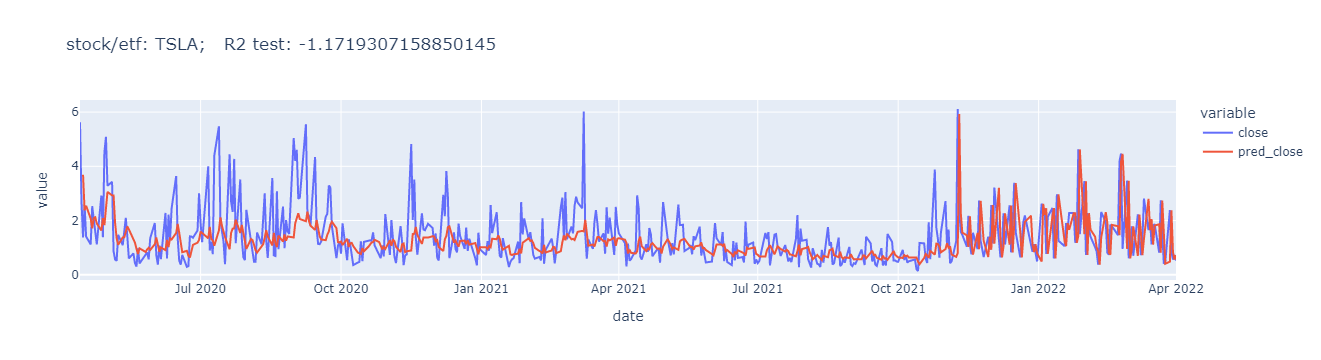

In [29]:

real['pred_close'] = predictions

fig = px.line(real, x="date", y=["close", "pred_close"], title = 'stock/etf: '+ symbol + ';   R2 test: '+str(R2_test))

fig

# SERIALIZAR EL MODELO

modelo a guardar

In [30]:
fitted_model

guardamos el modelo

In [31]:
# pickle.dump(fitted_model, open('ARIMA_model.pkl', 'wb'))

cargamos el modelo

In [32]:
import pickle
new_model = pickle.load(open('ARIMA_model.pkl', 'rb'))

In [33]:
# new_predictions = new_model.predict()